# Data Loading

Must receive the following files:  
- `tmat`: transition matrix (Sbar x Abar x Sbar). Must be normalized and include terminal states.
- `mortprobs`: mortality probabilities ((Sbar - 2) x Abar)  
- `urine_avg`, `map_avg`: average urine and MAP levels for each non-mort cluster (Sbar - 2) 

**Note** we assume in the transition matrix that A comes before D in the mortality states. 

In [1]:
import numpy as np

In [97]:
# load above files here

version_date = '12012021'

tmat = np.load(f'../results//tmat_hierarchical_large_only_{version_date}.npy')
mortprobs = np.load(f'../MIMIC_dp_eda/mortprobs_hierarchical_large_only_{version_date}.npy')
urine_avg = np.load(f'../MIMIC_dp_eda/urines_hierarchical_large_only_{version_date}.npy')
map_avg = np.load(f'../MIMIC_dp_eda/maps_hierarchical_large_only_{version_date}.npy')
tsa = np.load(f'../MIMIC_dp_eda/tsa_hierarchical_large_only_{version_date}.npy')
tsa_norm = np.load(f'../MIMIC_dp_eda/tsa_norm_hierarchical_large_only_{version_date}.npy')

KCONST = tmat.shape[0] - 2
tmat[KCONST, :, :] = 0
tmat[KCONST+1, :, :] = 0
tmat[KCONST, :, KCONST] = 1
tmat[KCONST+1, :, KCONST+1] = 1

# Fill up transition matrix. 
# If not sum to 1, make evenly distributed
xs, ys = np.where(np.sum(tmat, axis=2) == 0)
for x, y in zip(xs, ys):
    tmat[x, y] = 1 / (tmat.shape[2])

# Preprocessing

Make sure that T is stochastic, otherwise your algorithm will not converge, and that mort states are terminal.

In [99]:
print(tmat[KCONST, :, KCONST])
print(tmat[KCONST+1, :, KCONST+1])

[1. 1. 1. 1.]
[1. 1. 1. 1.]


In [100]:
tsa_norm.shape

(19, 4)

In [101]:
#unseen_x, unseen_y = np.where((np.abs(np.sum(tmat[:-2], axis=2) - 1) < 1e-4) == False)
unseen_x, unseen_y = np.where((tsa < 3) | (tsa_norm < 0.1))


In [102]:
unseen_x, unseen_y

(array([ 0,  0,  0,  1,  1,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,
         8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 16, 16,
        17, 18]),
 array([1, 2, 3, 2, 3, 1, 2, 3, 2, 3, 1, 2, 3, 0, 1, 0, 1, 2, 3, 2, 3, 0,
        1, 2, 3, 0, 1, 0, 1, 0, 1, 1, 0, 2, 3, 1]))

## Reward Functions

1: piecewise function based on average urine and MAP of `s'`. For mort states, r(A) = 0 and r(D) = -1 (the extremes of the piecewise reward).

In [103]:
URINE_OUTPUT_THRESH = 30 #if urine is above this, we're not too worried about BP if it's above 55
MAP_UO_THRESH = 55 #as long as MAP is above this, give max reward as long as UO is ok

def lin_reward_func(bps, cutoffs=[60, 75, 80, 85], vals=[-1, -0.15, -0.05, 0]):
    return np.interp(bps, cutoffs, vals)

In [ ]:
piecewise_vec = lin_reward_func(map_avg)
piecewise_vec = np.append(piecewise_vec, [0, 0]) # add room for mort states

piecewise_reward = np.tile(piecewise_vec, (KCONST + 2, 4, 1))

piecewise_reward[:, :, KCONST+1] = -1
piecewise_reward[KCONST+1, :, KCONST+1] = 0 # accts for repeating terminating state
piecewise_reward[unseen_x, unseen_y] = -100

2: inverse of the mortality probability for `(s, a)`.  
For now, we use negative of the probability. 0 reward for leaving a mort state.

In [105]:
mortprob_small = np.concatenate([-mortprobs, np.zeros((2, 4))])
mortprob_small = np.expand_dims(mortprob_small, axis=2)

mortprob_reward = np.tile(mortprob_small, (1, 1, KCONST + 2))

mortprob_reward[KCONST, :, :] = 0
mortprob_reward[KCONST+1, :, :] = 0
mortprob_reward[unseen_x, unseen_y] = -100

3: terminal 1/0 reward for A/D states, respectively, based on `s'`. 

In [106]:
terminal_reward = np.zeros((KCONST + 2, 4, KCONST + 2))
terminal_reward[:, :, KCONST] = 0
terminal_reward[KCONST, :, KCONST] = 0 # accts for repeating terminating state
terminal_reward[:, :, KCONST+1] = -1
terminal_reward[KCONST + 1, :, KCONST + 1] = 0
terminal_reward[unseen_x, unseen_y] = -100

You should now have three reward functions in `(Sbar, Abar, Sbar)` shape: `piecewise_reward`, `mortprob_reward`, and `terminal_reward`. 

# Planning Algorithm

Value-iteration (cross-checked against MDP toolbox, Andrew's CS282 HW1 solution). 

In [107]:
def vi(T, R, discount, tolerance=1e-3, max_iters=1000):
    '''
        Takes in transition matrix and reward matrix of the same shapes. 
        Returns the estimated Q-function and deterministic policy.
    '''
    
    num_s = T.shape[0]
    num_a = T.shape[1]
    Q = np.random.uniform(size=(num_s, num_a))
    #Q = np.zeros((num_s, num_a))
    Q[KCONST, :] = 0
    Q[KCONST+1, :] = 0
    V = np.amax(Q, axis=1)
    
    # training
    for i in range(max_iters):
        v = V
        Q = np.sum(np.multiply(T, R) + discount * T * V, axis=2)
        V = np.amax(Q, axis=1)
        if np.max(np.abs(v - V)) < tolerance: break
    print(i, 'iterations to convergence')
    
    return np.argmax(Q, axis=1), Q, np.sum(np.multiply(T, R), axis=2)

# Results

Now, we can run and save the policies obtained from each of the above rewards.

8 iterations to convergence
8 iterations to convergence
11 iterations to convergence


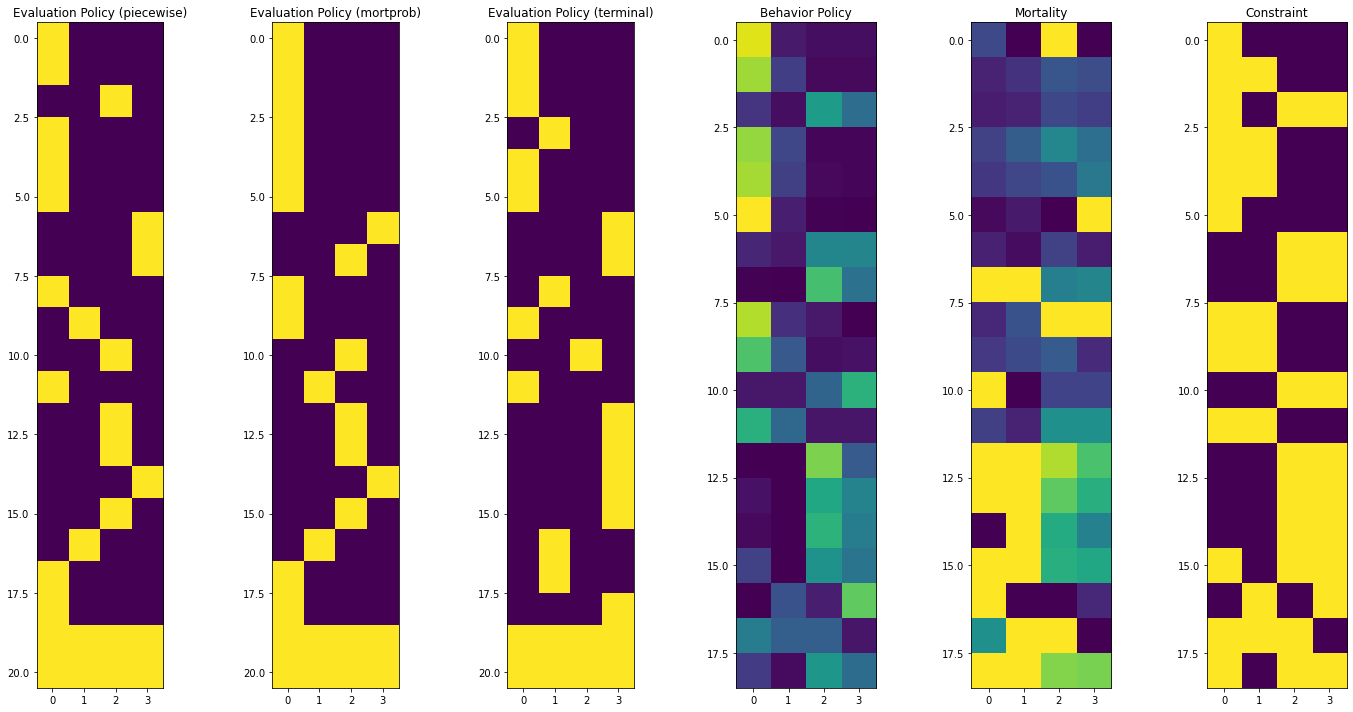

In [108]:
DISCOUNT = 0.98 # may want to set to 1?
np.set_printoptions(precision=2, suppress=True)

piecewise_pi, piecewise_Q, piecewise_R = vi(tmat, piecewise_reward, DISCOUNT)
mortprob_pi, mortprob_Q, mortprob_R = vi(tmat, mortprob_reward, DISCOUNT)
terminal_pi, terminal_Q, terminal_R = vi(tmat, terminal_reward, DISCOUNT)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,6, figsize=(20,10))
ax[0].imshow(np.where(piecewise_Q == np.max(piecewise_Q, axis=1, keepdims=True), 1, 0))
ax[0].set_title("Evaluation Policy (piecewise)")
ax[1].imshow(np.where(mortprob_Q == np.max(mortprob_Q, axis=1, keepdims=True), 1, 0))
ax[1].set_title("Evaluation Policy (mortprob)")
ax[2].imshow(np.where(terminal_Q == np.max(terminal_Q, axis=1, keepdims=True), 1, 0))
ax[2].set_title("Evaluation Policy (terminal)")
ax[3].imshow(tsa_norm)
ax[3].set_title("Behavior Policy")
ax[4].imshow(mortprobs)
ax[4].set_title("Mortality")
a = np.zeros_like(tsa_norm)
a[unseen_x, unseen_y]=-1
ax[5].imshow(a)
ax[5].set_title("Constraint")
plt.tight_layout()
plt.show()

In [109]:
DISCOUNT = 0.98 # may want to set to 1?
np.set_printoptions(precision=2, suppress=True)

In [110]:
piecewise_pi, piecewise_Q, piecewise_R = vi(tmat, piecewise_reward, DISCOUNT)

8 iterations to convergence


In [111]:
mortprob_pi, mortprob_Q, mortprob_R = vi(tmat, mortprob_reward, DISCOUNT)

8 iterations to convergence


In [112]:
terminal_pi, terminal_Q, terminal_R = vi(tmat, terminal_reward, DISCOUNT)

11 iterations to convergence


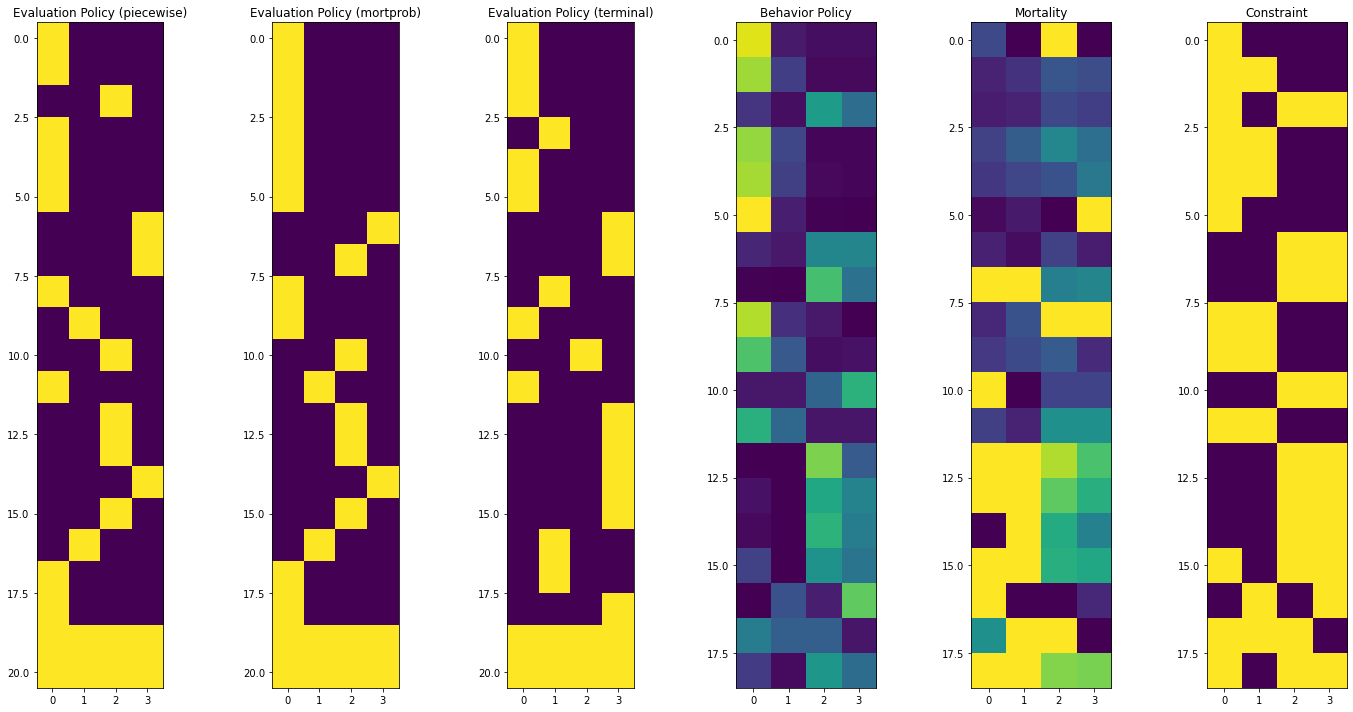

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,6, figsize=(20,10))
ax[0].imshow(np.where(piecewise_Q == np.max(piecewise_Q, axis=1, keepdims=True), 1, 0))
ax[0].set_title("Evaluation Policy (piecewise)")
ax[1].imshow(np.where(mortprob_Q == np.max(mortprob_Q, axis=1, keepdims=True), 1, 0))
ax[1].set_title("Evaluation Policy (mortprob)")
ax[2].imshow(np.where(terminal_Q == np.max(terminal_Q, axis=1, keepdims=True), 1, 0))
ax[2].set_title("Evaluation Policy (terminal)")
ax[3].imshow(tsa_norm)
ax[3].set_title("Behavior Policy")
ax[4].imshow(mortprobs)
ax[4].set_title("Mortality")
a = np.zeros_like(tsa_norm)
a[unseen_x, unseen_y]=-1
ax[5].imshow(a)
ax[5].set_title("Constraint")
plt.tight_layout()
plt.show()

## Saving Policies

In [ ]:
result_dir = "../results/model"

In [114]:
np.save((f'{result_dir}/piecewise_pi_' + version_date), piecewise_pi)
np.save((f'{result_dir}/mortprob_pi_' + version_date), mortprob_pi)
np.save((f'{result_dir}/terminal_pi_' + version_date), terminal_pi)

In [115]:
np.save((f'{result_dir}/piecewise_Q_' + version_date), piecewise_Q)
np.save((f'{result_dir}/mortprob_Q_' + version_date), mortprob_Q)
np.save((f'{result_dir}/terminal_Q_' + version_date), terminal_Q)

In [116]:
np.save((f'{result_dir}/piecewise_R_' + version_date), piecewise_R)
np.save((f'{result_dir}/mortprob_R_' + version_date), mortprob_R)
np.save((f'{result_dir}/terminal_R_' + version_date), terminal_R)